In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import textwrap

import numpy as np
import pandas as pd
from scipy.stats import chi2

import plotly.express as ex
import plotly.graph_objects as go

from tracking_v2.kalman.turn import CoordinatedTurn
from tracking_v2.sensor import GeometricSensor
from tracking_v2.target import SingleTurnTarget, SinusTarget
from tracking.util import to_df

In [4]:
def moving_average(data, half_window_size):
    x = (np.arange(2*half_window_size + 1) - half_window_size - 1) / half_window_size * 2
    w = np.exp(-np.power(x, 2))
    w = w / np.sum(w)
    return np.convolve(data, w, 'same')

## Pick sigmas for process noise

### Heading noise as a function of Cartesian position noise

We consider a Coordinated Turn KF with 5-dimensional state representation: position and velocity in XY, and a turn rate. Process noise variance is the spatial XY dimensions depends on internal and external factors: target changing speed or turn rate, wind, and can be derived from assumptions about the target and the environment. However, process noise for the turn rate dimension must be derived from the known spatial process and measurement noise values.

Below, we present the turn rate noise in the function of target speed and total spatial noise.

In [5]:
def alpha_stdev(spatial_sigma, speed, N=1000):
    x0 = np.random.normal(0, spatial_sigma, (N, 2))
    x1 = np.hstack((np.random.normal(speed, spatial_sigma, (N, 1)), np.random.normal(0, spatial_sigma, (N, 1))))

    alpha = np.arctan2(x1[:,1] - x0[:,1], x1[:,0] - x0[:,0])
    return np.std(alpha)


data = []
for speed in range(1, 50, 5):
    for sigma in [.1, .2, .5, 1, 2, 5, 10]:
        data.append((speed, sigma, alpha_stdev(sigma, speed)))

data = to_df(np.array(data), columns=['speed', 'sigma', 'alpha_stdev'])

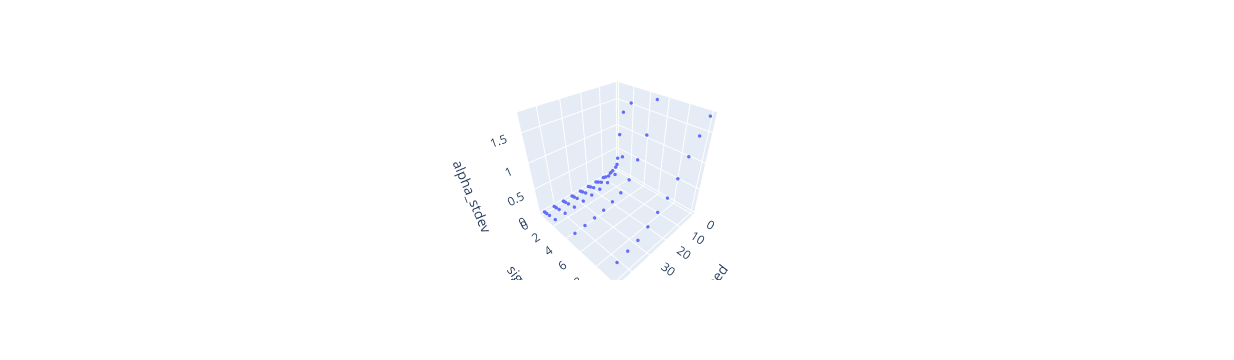

In [6]:
fig = ex.scatter_3d(data, x='speed', y='sigma', z='alpha_stdev')
fig.update_traces(marker_size=2)
fig

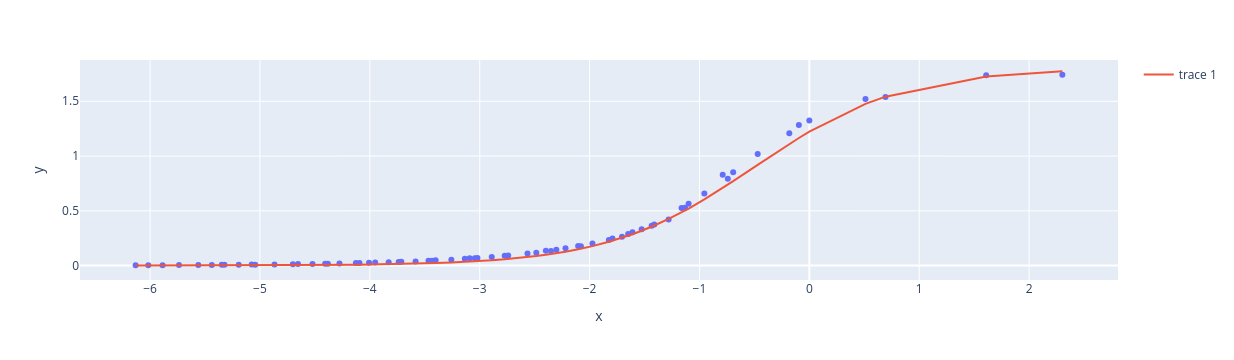

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

fig = ex.scatter(x=-np.log(data['speed'] / data['sigma']), y=data['alpha_stdev'])

x = np.sort(-np.log(data['speed'] / data['sigma']))
fig.add_trace(go.Scatter(x=x, y=1.8*sigmoid(1.5*(x+.5))))
fig

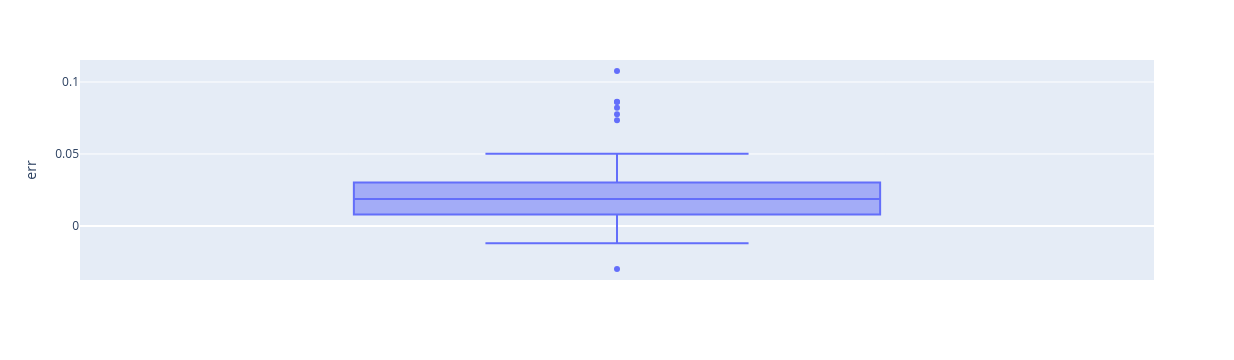

In [8]:
def derive_alpha_stdev(speed, sigma):
    return 1.8 * sigmoid(1.5 * (np.log(sigma / speed) + .5))

err = []
for speed in range(1, 50, 5):
    for sigma in [.1, .2, .5, 1, 2, 5, 10]:
        err.append((speed, sigma, alpha_stdev(sigma, speed) - derive_alpha_stdev(speed, sigma)))

err = to_df(np.array(err), columns=['speed', 'sigma', 'err'])
ex.box(err, y='err')

## Single turn

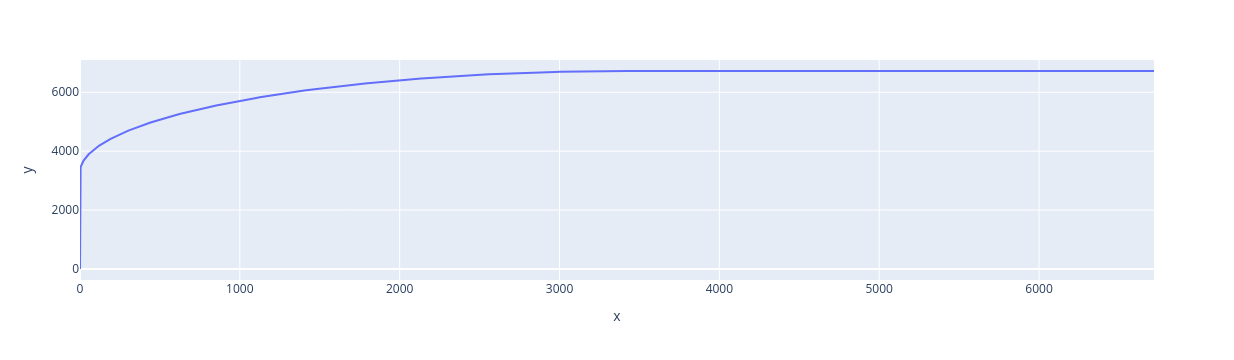

In [10]:
target = SingleTurnTarget(30, .5)
sensor = GeometricSensor(seed=0)
true_positions = target.true_states()

ex.line(x=true_positions[:, 0], y=true_positions[:, 1])

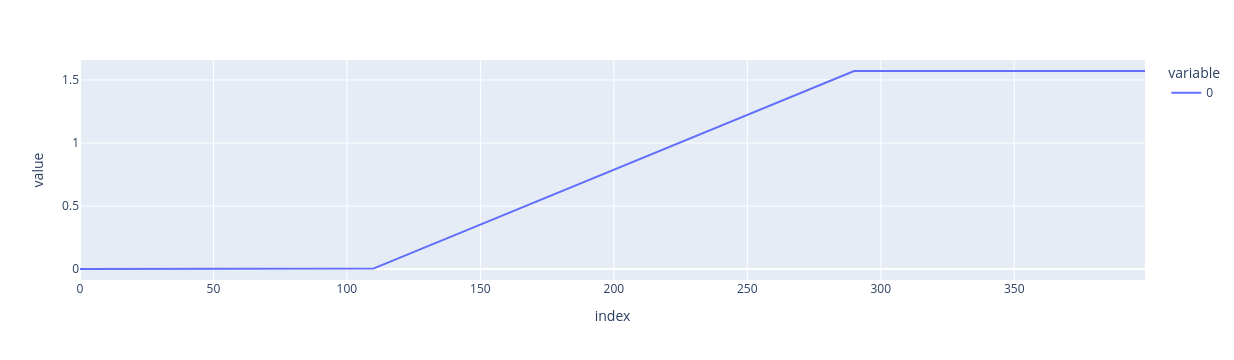

In [11]:
ex.line(target.heading())

In [12]:
derive_alpha_stdev(30, 1)

0.02289559440040238

In [13]:
ct = CoordinatedTurn([[1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0]],
                      [1, .02289])
t = 0
ct.initialize(true_positions[t, :2], np.eye(2))

x = []
for _ in range(399):
    t += 1
    m = sensor.generate_measurement(t, true_positions[t, :3])

    ct.predict(1)
    ct.update(m.z[:, :2], m.R[:2, :2])

    x.append(ct.x_hat)

x = np.array(x).squeeze()

In [14]:
df = to_df(np.hstack((
                np.arange(399).reshape((-1, 1)),
                true_positions[1:, :2],
                target.heading()[1:].reshape((-1, 1)),
                np.diff(target.heading()).reshape((-1, 1)),
                x)),
           columns=['t', 'x', 'y', 'heading', 'Omega', 'x_hat', 'x_dot_hat', 'y_hat', 'y_dot_hat', 'Omega_hat'])

df['Omega_smooth'] = moving_average(df['Omega_hat'], 5)

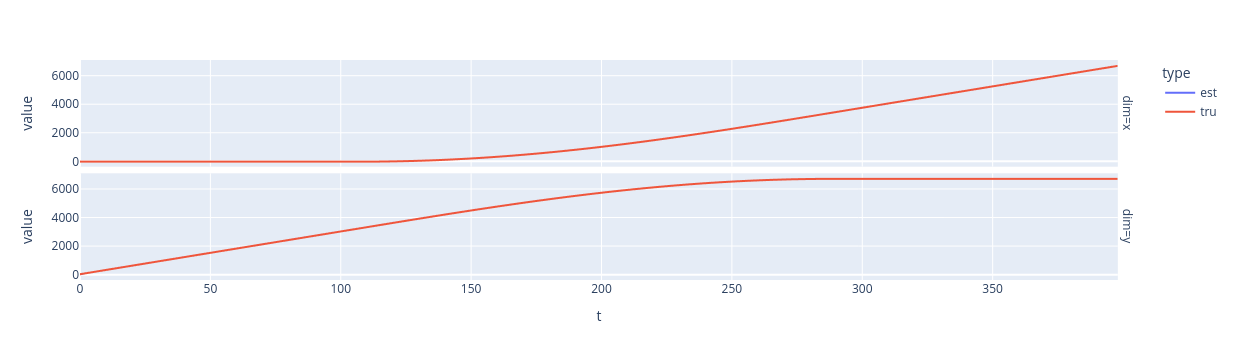

In [15]:
est = df[['t', 'x_hat', 'y_hat']].rename(columns=dict(x_hat='x', y_hat='y')).melt(['t'], ['x', 'y'], 'dim').assign(type='est')
tru = df[['t', 'x', 'y']].melt(['t'], ['x', 'y'], 'dim').assign(type='tru')
ex.line(pd.concat((est, tru)), x='t', y='value', color='type', facet_row='dim')

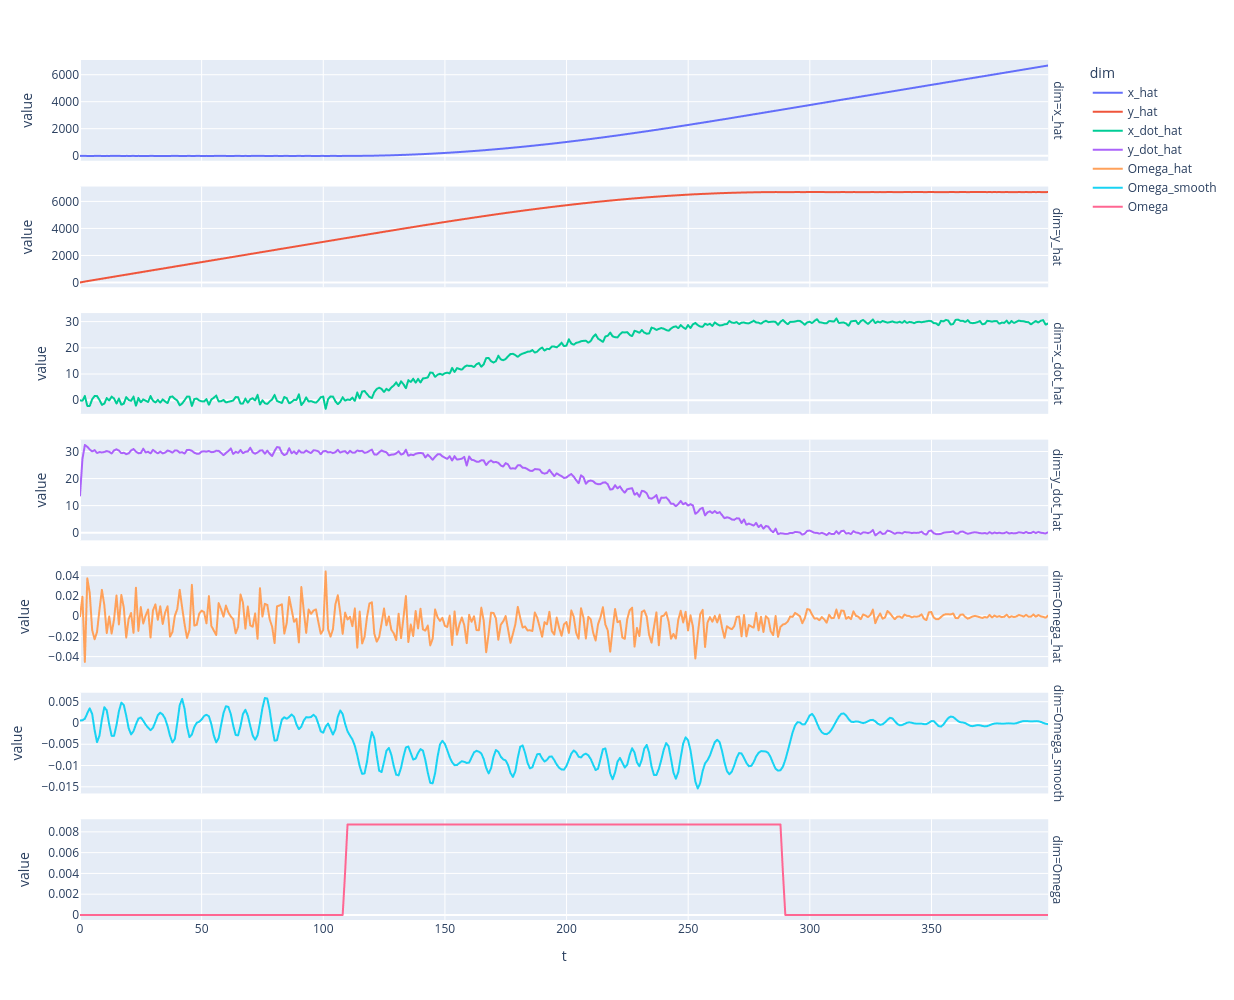

In [16]:
fig = ex.line(df.melt(['t'], ['x_hat', 'y_hat', 'x_dot_hat', 'y_dot_hat', 'Omega_hat', 'Omega_smooth', 'Omega'], 'dim'),
              x='t', y='value', color='dim', facet_row='dim')
fig.update_yaxes(matches=None)
fig.update_layout(height=1000)
fig

## Multiple turns

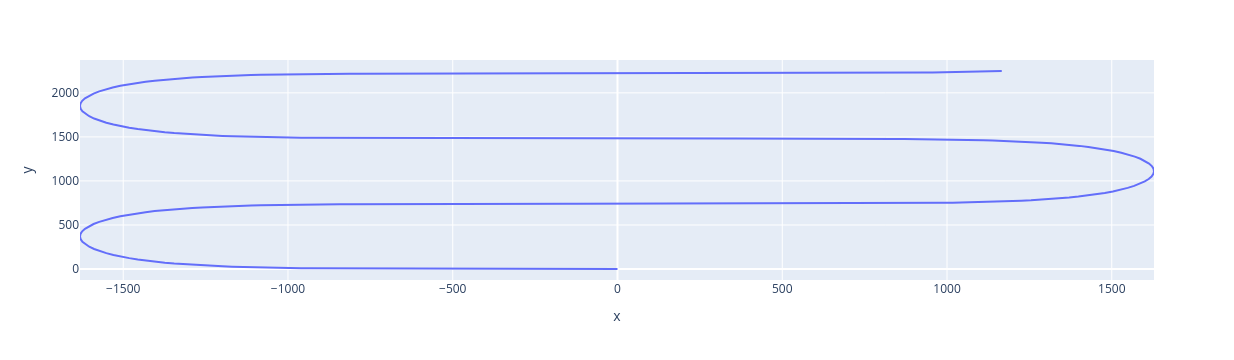

In [17]:
target = SinusTarget(30, 3)
sensor = GeometricSensor(seed=0)
true_positions = target.true_states()

ex.line(x=true_positions[:, 0], y=true_positions[:, 1])

In [18]:
ct = CoordinatedTurn([[1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0]],
                     [1, .02289])
t = 0
ct.initialize(true_positions[t, :2], np.eye(2))

In [19]:
x = []
for _ in range(399):
    t += 1
    m = sensor.generate_measurement(t, true_positions[t, :3])

    ct.predict(1)
    ct.update(m.z[:, :2], m.R[:2, :2])

    x.append(ct.x_hat)

x = np.array(x).squeeze()

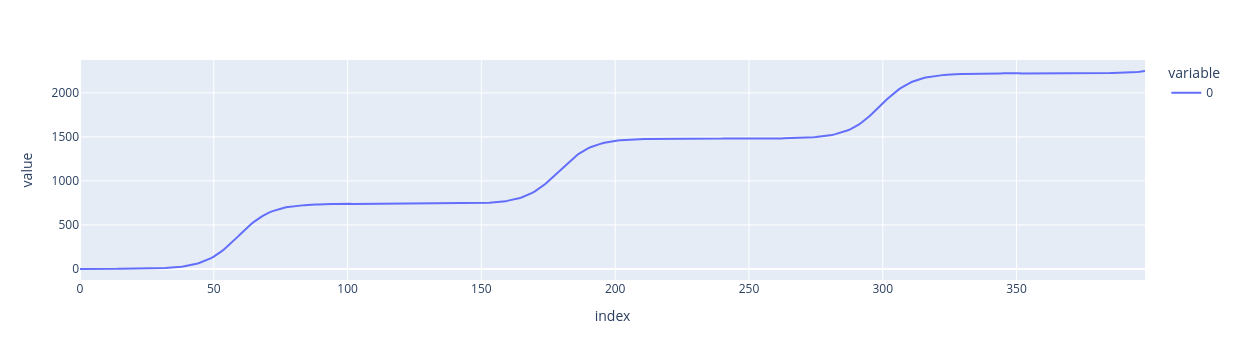

In [20]:
ex.line(x[:,2])

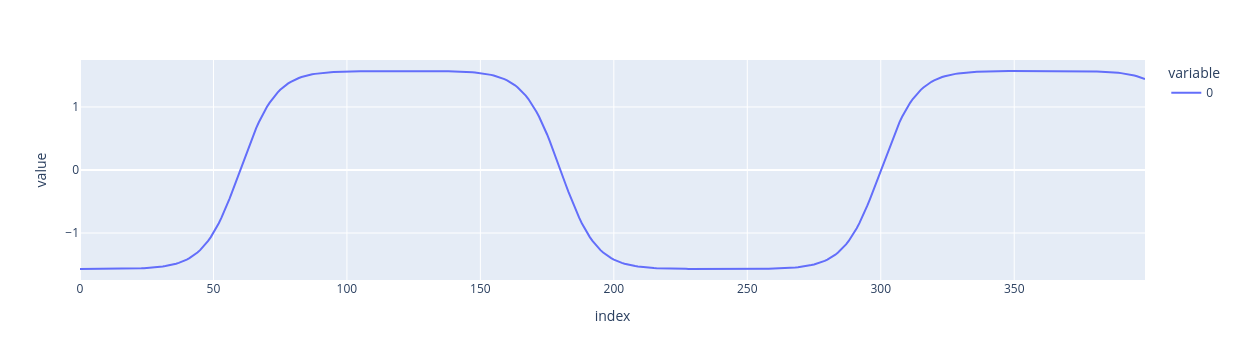

In [21]:
ex.line(target.heading())

In [22]:
df = to_df(np.hstack((np.arange(399).reshape((-1, 1)), true_positions[1:, :2], x)),
           columns=['t', 'x', 'y', 'x_hat', 'x_dot_hat', 'y_hat', 'y_dot_hat', 'Omega'])
df

t            x            y        x_hat  x_dot_hat        y_hat  \
0      0.0   -29.999997     0.012453   -20.682185 -13.788123    -0.082836   
1      1.0   -59.999994     0.026921   -53.802281 -27.612141    -0.479147   
2      2.0   -89.999989     0.043731   -86.967618 -31.437187     0.999659   
3      3.0  -119.999983     0.063260  -120.553130 -33.042061    -0.293617   
4      4.0  -149.999974     0.085949  -152.632463 -32.394260    -0.239842   
..     ...          ...          ...          ...        ...          ...   
394  394.0  1046.738414  2236.585295  1046.389969  29.738042  2237.541804   
395  395.0  1076.648971  2238.898111  1077.199333  30.391035  2238.850729   
396  396.0  1106.529215  2241.573639  1107.932522  30.602565  2241.090623   
397  397.0  1136.369081  2244.666490  1135.789975  28.858717  2243.896507   
398  398.0  1166.155278  2248.238664  1165.190385  29.236171  2248.794767   

     y_dot_hat     Omega  
0    -0.055224  0.000000  
1    -0.616721  0.035852  
2     2.175786 -0.067135  
3    -0.732662  0.015116  
4    -0.212677  0.002190  
..         ...       ...  
394   2.143923  0.006568  
395   2.076991  0.004982  
396   2.257438  0.005014  
397   2.578000  0.006906  
398   3.446813  0.009981  

[399 rows x 8 columns]

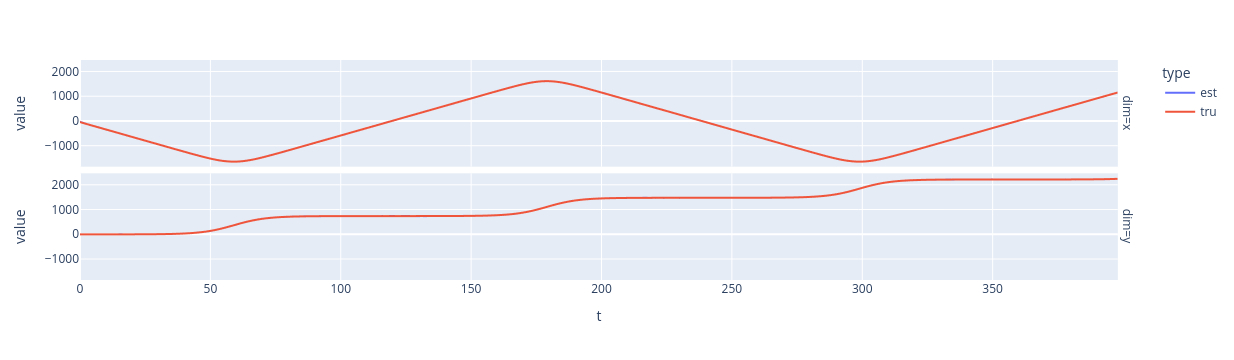

In [23]:
est = df[['t', 'x_hat', 'y_hat']].rename(columns=dict(x_hat='x', y_hat='y')).melt(['t'], ['x', 'y'], 'dim').assign(type='est')
tru = df[['t', 'x', 'y']].melt(['t'], ['x', 'y'], 'dim').assign(type='tru')
ex.line(pd.concat((est, tru)), x='t', y='value', color='type', facet_row='dim')

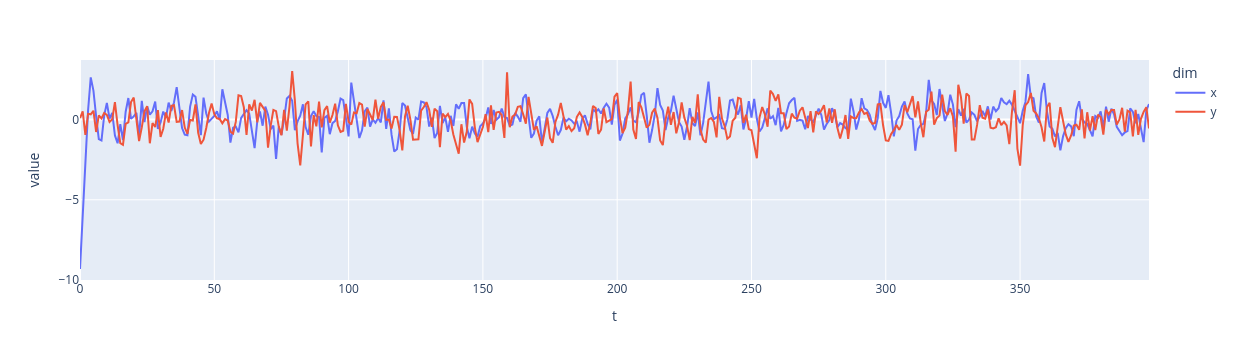

In [24]:
err = to_df(np.vstack((np.arange(399), true_positions[1:, 0]-x[:,0], true_positions[1:, 1]-x[:,2])).T,
           columns=['t', 'x', 'y'])
ex.line(err.melt(['t'], ['x', 'y'], 'dim'), x='t', y='value', color='dim')

In [31]:
df = to_df(np.hstack((np.arange(399).reshape((-1, 1)), true_positions[1:, :2], np.diff(-target.heading()).reshape((-1, 1)), x)),
           columns=['t', 'x', 'y', 'Omega', 'x_hat', 'x_dot_hat', 'y_hat', 'y_dot_hat', 'Omega_hat'])

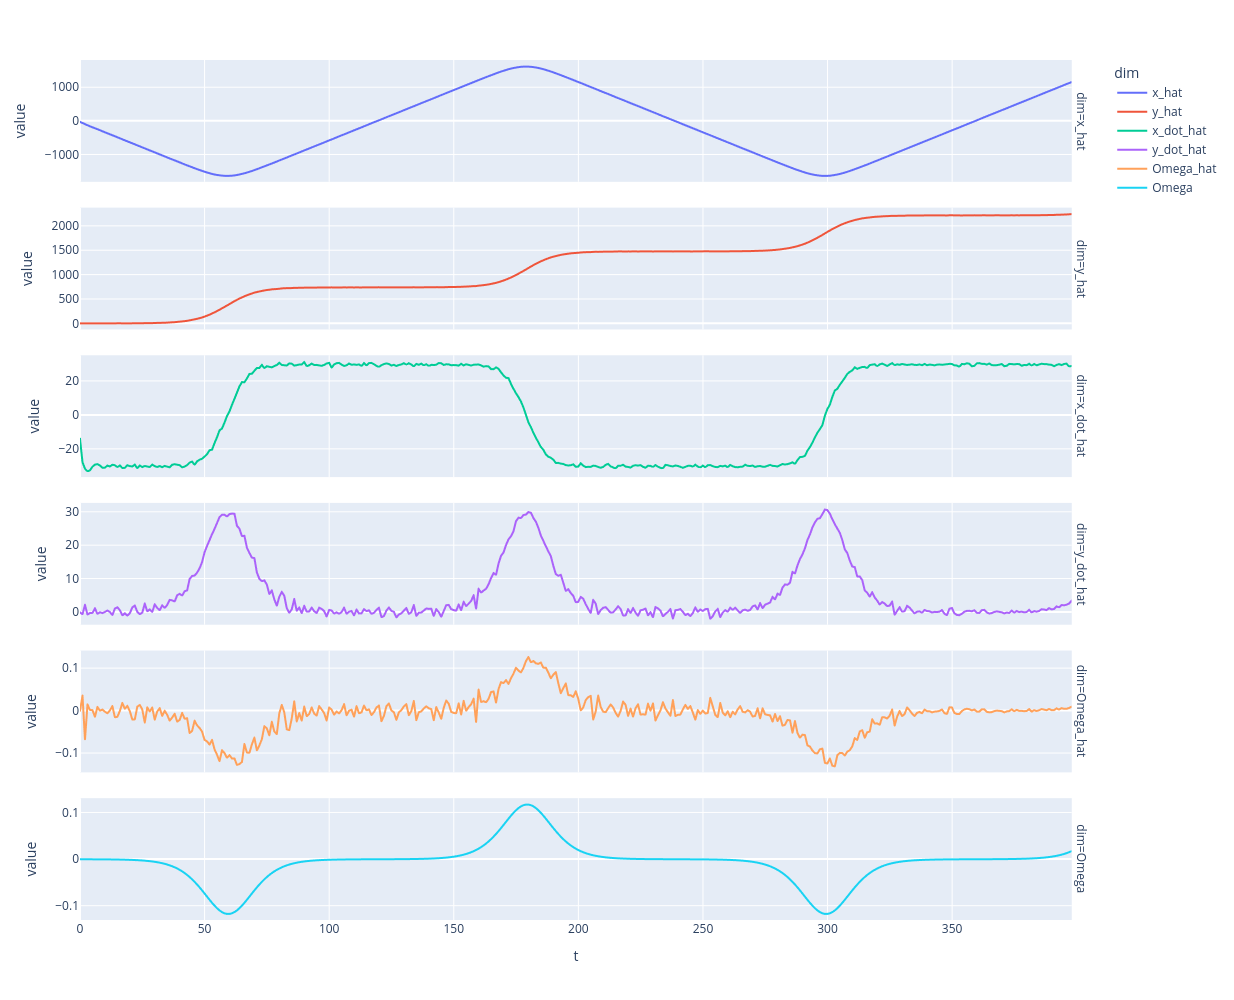

In [32]:
fig = ex.line(df.melt(['t'], ['x_hat', 'y_hat', 'x_dot_hat', 'y_dot_hat', 'Omega_hat', 'Omega'], 'dim'),
              x='t', y='value', color='dim', facet_row='dim')
fig.update_yaxes(matches=None)
fig.update_layout(height=1000)
fig